In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.stattools as st
from arch import arch_model
from scipy.optimize import minimize

In [20]:
data = pd.read_csv('usdata.csv')
data

,obs,FFR,GDP,CPI
0,1954Q3,0.010267,-1.564017,0.153015
1,1954Q4,0.009867,-1.544422,0.152446
2,1955Q1,0.013433,-1.516031,0.151877
3,1955Q2,0.015000,-1.499793,0.151877
4,1955Q3,0.019400,-1.486542,0.152446
...,...,...,...,...
204,2005Q3,0.034600,0.118237,1.117179
205,2005Q4,0.039800,0.122609,1.124005
206,2006Q1,0.044567,0.136186,1.130262
207,2006Q2,0.049067,0.142502,1.151877


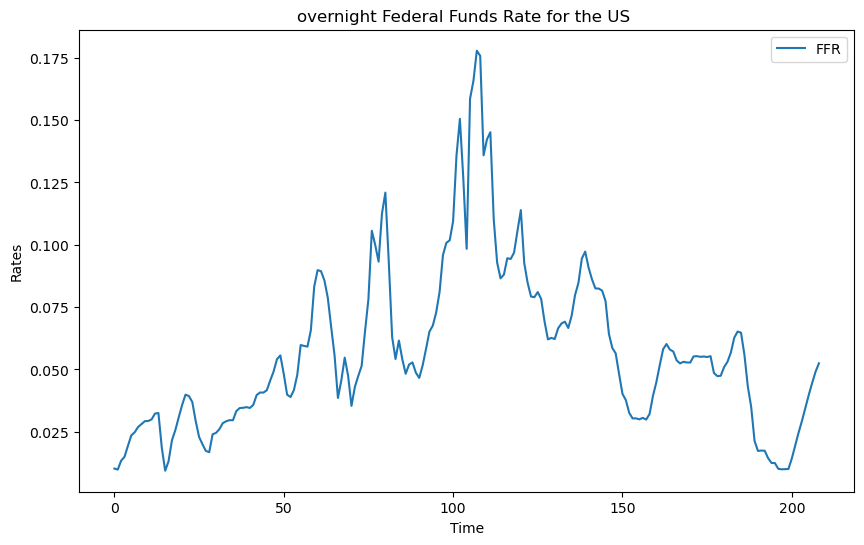

In [33]:
y = data['FFR']


plt.figure(figsize=(10, 6))
plt.plot(y, label='FFR')
plt.title('overnight Federal Funds Rate for the US ')
plt.xlabel('Time')
plt.ylabel('Rates')
plt.legend()
plt.show()

####  ${r_t}$ does not seem to be stationary as its mean appears to be time varying. However, there is no apparent deterministic trend.

In [34]:
# delta ffr
dy = y.diff()

# Lag
y_lag = y.shift(1)
dy_lag = dy.shift(1)

trend = np.arange(len(y))

df = pd.DataFrame({
    'y'    : y,
    'dy'   : dy,
    'y_lag': y_lag,
    'trend': trend,
    'dy_lag': dy_lag   
}).dropna()

df

,y,dy,y_lag,trend,dy_lag
2,0.013433,0.003567,0.009867,2,-0.000400
3,0.015000,0.001567,0.013433,3,0.003567
4,0.019400,0.004400,0.015000,4,0.001567
5,0.023567,0.004167,0.019400,5,0.004400
6,0.024833,0.001267,0.023567,6,0.004167
...,...,...,...,...,...
204,0.034600,0.005167,0.029433,204,0.004733
205,0.039800,0.005200,0.034600,205,0.005167
206,0.044567,0.004767,0.039800,206,0.005200
207,0.049067,0.004500,0.044567,207,0.004767


### We conduct the ADF test ($\tau$) using the following equation : $\Delta y_{t} = \gamma y_{t-1} + \beta \Delta y_{t-1} + \epsilon_{t}$

In [35]:
X = df[['y_lag', 'dy_lag']]
Y = df['dy']

model = sm.OLS(Y, X)
results = model.fit()

print(results.summary())
print('Sum of Squared Residuals (SSR):', results.ssr)

                                 OLS Regression Results                                
Dep. Variable:                     dy   R-squared (uncentered):                   0.062
Model:                            OLS   Adj. R-squared (uncentered):              0.053
Method:                 Least Squares   F-statistic:                              6.775
Date:                Mon, 25 Sep 2023   Prob (F-statistic):                     0.00142
Time:                        19:15:15   Log-Likelihood:                          677.26
No. Observations:                 207   AIC:                                     -1351.
Df Residuals:                     205   BIC:                                     -1344.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

The $\tau$ statistic: No Constant or Time Trend (a0 = a2 = 0)

#### critical values for sample size T = 250 are: 

-1.95 at 5% significant level 

-1.62 at 10% significant level

So we fail to reject the null!

### We conduct the ADF test ($\tau_{\mu}$) using the following equation : $\Delta y_{t} = a_{0} + \gamma y_{t-1} + \beta \Delta y_{t-1} + \epsilon_{t}$

In [36]:
X = df[['y_lag', 'dy_lag']]
X = sm.add_constant(X)
Y = df['dy']

model = sm.OLS(Y, X)
results = model.fit()

print(results.summary())
print('Sum of Squared Residuals (SSR):', results.ssr)

                            OLS Regression Results                            
Dep. Variable:                     dy   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     10.30
Date:                Mon, 25 Sep 2023   Prob (F-statistic):           5.50e-05
Time:                        19:15:27   Log-Likelihood:                 680.64
No. Observations:                 207   AIC:                            -1355.
Df Residuals:                     204   BIC:                            -1345.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.001      2.601      0.0

The $\tau_{\mu}$ statistic: Constant but No Time Trend (a2 = 0)

#### critical values for sample size T = 250 are: 

-2.88 at 5% significant level 

-2.58 at 10% significant level

So we reject the null!

### We conduct the ADF test ($\tau_{\tau}$) using the following equation : $\Delta y_{t} = a_{0} + \gamma y_{t-1} + a_{2}t + \beta \Delta y_{t-1} + \epsilon_{t}$

In [37]:
X = df[['y_lag', 'trend', 'dy_lag']]
X = sm.add_constant(X)
Y = df['dy']

model = sm.OLS(Y, X)
results = model.fit()

print(results.summary())
print('Sum of Squared Residuals (SSR):', results.ssr)

                            OLS Regression Results                            
Dep. Variable:                     dy   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     6.846
Date:                Mon, 25 Sep 2023   Prob (F-statistic):           0.000204
Time:                        19:15:31   Log-Likelihood:                 680.66
No. Observations:                 207   AIC:                            -1353.
Df Residuals:                     203   BIC:                            -1340.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.002      2.168      0.0

The $\tau_\tau$ statistic: Constant + Time Trend

#### critical values for sample size T = 250 are: 

-3.43 at 5% significant level 

-3.13 at 10% significant level

### So we fail reject the null! we can conclude the series has at least one unit root. We continue further with $\Phi_2$ and $\Phi_3$  tests for the option of a deterministic trend in addition to the stochastic trend.

In [38]:
def F_statistic(SSR_restricted, SSR_unrestricted, r, T, k):
    phi = ((SSR_restricted - SSR_unrestricted)/r)/(SSR_unrestricted/(T - k))
    return phi

'''
r = number of restrictions
T = number of usable observations
k = number of parameters estimated in the unrestricted model
'''

'\nr = number of restrictions\nT = number of usable observations\nk = number of parameters estimated in the unrestricted model\n'

### Unrestricted model:
$\Delta y_{t} = a_{0} + \gamma y_{t-1} + a_{2}t + \beta \Delta y_{t-1}+ \epsilon_{t}$

In [39]:
X = df[['y_lag','trend', 'dy_lag']]
X = sm.add_constant(X)
Y = df['dy']

model = sm.OLS(Y, X)
results = model.fit()

print(results.summary())
print('Sum of Squared Residuals (SSR) for restricted model:', results.ssr)
SSR_unrestricted = results.ssr

                            OLS Regression Results                            
Dep. Variable:                     dy   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     6.846
Date:                Mon, 25 Sep 2023   Prob (F-statistic):           0.000204
Time:                        19:16:29   Log-Likelihood:                 680.66
No. Observations:                 207   AIC:                            -1353.
Df Residuals:                     203   BIC:                            -1340.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.002      2.168      0.0

### restricted model: 
$\Delta y_{t} = \beta \Delta y_{t-1} + \epsilon_{t}$

In [40]:
X = df[['dy_lag']]
Y = df['dy']

model = sm.OLS(Y, X)
results = model.fit()

print(results.summary())
print('Sum of Squared Residuals (SSR) for restricted model:', results.ssr)
SSR_restricted_phi_2 = results.ssr

                                 OLS Regression Results                                
Dep. Variable:                     dy   R-squared (uncentered):                   0.056
Model:                            OLS   Adj. R-squared (uncentered):              0.051
Method:                 Least Squares   F-statistic:                              12.11
Date:                Mon, 25 Sep 2023   Prob (F-statistic):                    0.000612
Time:                        19:16:32   Log-Likelihood:                          676.55
No. Observations:                 207   AIC:                                     -1351.
Df Residuals:                     206   BIC:                                     -1348.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [41]:
#%% Phi 2
'''
r = number of restrictions
T = number of usable observations
k = number of parameters estimated in the unrestricted model
'''
r = 3
T = len(df)
k = 4
phi_2 = F_statistic(SSR_restricted_phi_2, SSR_unrestricted, r, T, k)
print('phi_2 statistics = {}'.format(phi_2))

phi_2 statistics = 2.7429714903702003


The $\Phi_2 statistic: 

#### critical values for sample size T = 250 are: 

4.75 at 5% significant level 

4.07 at 10% significant level

#### So we fail reject the null! 

### restricted model: 
$\Delta y_{t} = a_{0} + \beta \Delta y_{t-1} + \epsilon_{t}$

In [42]:
X = df[['dy_lag']]
X = sm.add_constant(X)
Y = df['dy']

model = sm.OLS(Y, X)
results = model.fit()

print(results.summary())
print('Sum of Squared Residuals (SSR) for restricted model:', results.ssr)
SSR_restricted_phi_3 = results.ssr

                            OLS Regression Results                            
Dep. Variable:                     dy   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     12.01
Date:                Mon, 25 Sep 2023   Prob (F-statistic):           0.000643
Time:                        19:17:09   Log-Likelihood:                 676.58
No. Observations:                 207   AIC:                            -1349.
Df Residuals:                     205   BIC:                            -1342.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.251      0.8

In [43]:
#%% Phi 3
'''
r = number of restrictions
T = number of usable observations
k = number of parameters estimated in the unrestricted model
'''
r = 2
T = len(df)
k = 4
phi_3 = F_statistic(SSR_restricted_phi_3, SSR_unrestricted, r, T, k)
print('phi_3 statistics = {}'.format(phi_3))

phi_3 statistics = 4.081933421293336


The $\Phi_3 statistic: 

#### critical values for sample size T = 250 are: 

5.39 at 5% significant level 

6.34 at 10% significant level

#### So we fail to reject the null! 

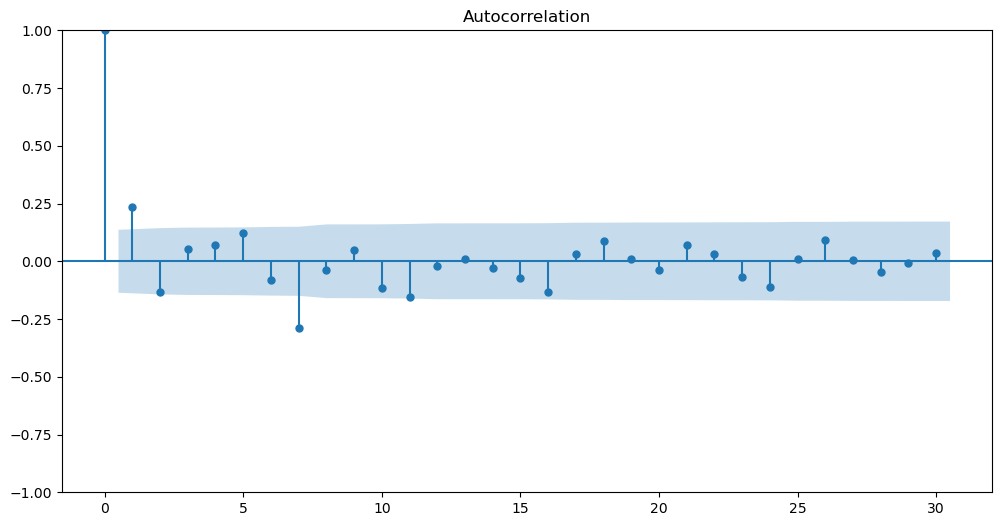

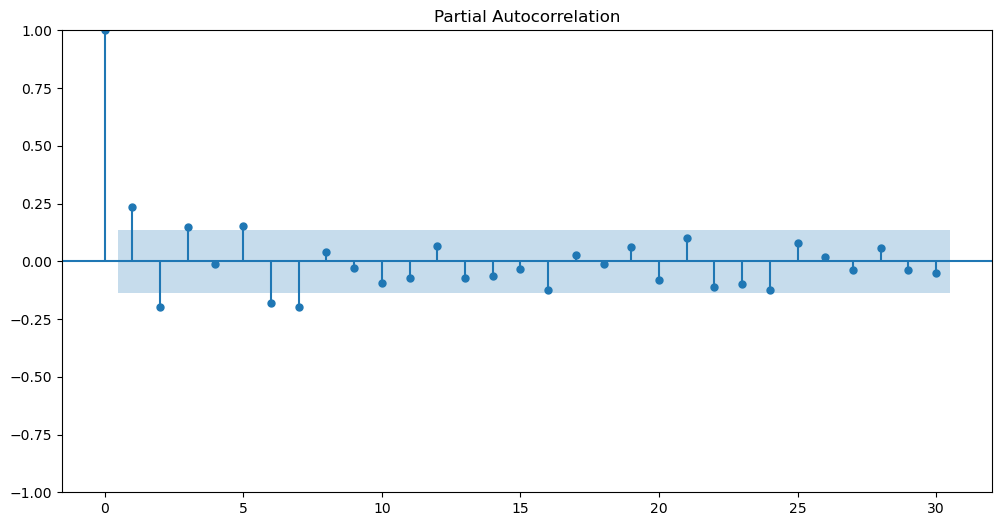

In [44]:
# Plot ACF
ts = df['dy']
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_acf(ts.values.squeeze(), lags=30, ax=ax)
plt.show()

# Plot PACF
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_pacf(ts.values.squeeze(), lags=30, ax=ax)
plt.show()

### Therefore, we consider ARIMA(1, 1, 1), ARIMA(2, 1, 1), ARIMA(1, 1, 2) for $\{y_{t}\}$

### ARIMA(1, 1, 1)

In [45]:
ts = data['FFR']
p = 1
d = 1
q = 1
model1 = sm.tsa.ARIMA(ts, order=(p, d, q)).fit()
print('ARIMA(1,1,1) Model aic:', model1.aic) 
print('ARIMA(1,1,1) Model bic:', model1.bic)

ARIMA(1,1,1) Model aic: -1366.019693258499
ARIMA(1,1,1) Model bic: -1356.0070790193952


In [46]:
ts = data['FFR']
p = 2
d = 1
q = 1
model2 = sm.tsa.ARIMA(ts, order=(p, d, q)).fit()
print('ARIMA(2,1,1) Model aic:', model2.aic) 
print('ARIMA(2,1,1) Model bic:', model2.bic)

ARIMA(2,1,1) Model aic: -1366.1581437819807
ARIMA(2,1,1) Model bic: -1352.8079914631753


In [47]:
ts = data['FFR']
p = 1
d = 1
q = 2
model3 = sm.tsa.ARIMA(ts, order=(p, d, q)).fit()
print('ARIMA(1,1,2) Model aic:', model3.aic) 
print('ARIMA(1,1,2) Model bic:', model3.bic)

ARIMA(1,1,2) Model aic: -1366.3674498460496
ARIMA(1,1,2) Model bic: -1353.0172975272444


### ARIMA(1, 1, 1), ARIMA(2, 1, 1), ARIMA(1, 1, 2) have similar AIC. But We choose ARIMA(1, 1, 1) as it has the smallest BIC.

In [48]:
print(model1.summary())

                               SARIMAX Results                                
Dep. Variable:                    FFR   No. Observations:                  209
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 686.010
Date:                Mon, 25 Sep 2023   AIC                          -1366.020
Time:                        19:28:01   BIC                          -1356.007
Sample:                             0   HQIC                         -1361.971
                                - 209                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5118      0.072     -7.067      0.000      -0.654      -0.370
ma.L1          0.8240      0.045     18.409      0.000       0.736       0.912
sigma2      7.981e-05   2.89e-06     27.617      0.0